# Анализ данных сервиса аренды самокатов GoFast.

**Описание проекта:**  

Имеются данные мобильного приложения GoFast о некоторых пользователях из нескольких городов, а также об их поездках на самокатах. Для передвижения по городу, пользователи могут использовать сервис без подписки или с подпиской Ultra.   


**Цель проекта:**   

Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.  

**Описание данных:**  

Пользователи — **users_go.csv**  

`user_id` - уникальный идентификатор пользователя  
`name` - имя пользователя  
`age` - возраст  
`city` - город  
`subscription_type` - тип подписки (free, ultra)  

Поездки — **rides_go.csv**  

`user_id` - уникальный идентификатор пользователя  
`distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)  
`duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»  
`date` - дата совершения поездки  

Подписки — **subscriptions_go.csv**  

`subscription_type` - тип подписки  
`minute_price` - стоимость одной минуты поездки по данной подписке  
`start_ride_price` - стоимость начала поездки  
`subscription_fee` - стоимость ежемесячного платежа  


**План исследования:**  
- выгрузка и предобработка данных
- исследовательский анализ данных (описание и визуализация общей информации о пользователях и поездках)
- анализ информации о пользователях из обоих категорий (с подпиской и без), подсчет выручки.
- проверка гипотез
- выводы и рекомендации

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm 
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

## Шаг. Загрузка данных

In [2]:
# загружаем данные:

try:
    users,rides,subscriptions = (pd.read_csv('/datasets/users_go.csv'),
                                 pd.read_csv('/datasets/rides_go.csv'),
                                 pd.read_csv('/datasets/subscriptions_go.csv'))
except:
    users,rides,subscriptions = (pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\users_go.csv', sep = ','),
                                 pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\rides_go.csv', sep = ','),
                                 pd.read_csv(r'C:\Users\ANDREY\Documents\datasets\subscriptions_go.csv', sep = ','))

In [3]:
# функция для вывода необходимых характеристик датафрейма

def data_info(data):
    print(f'\033[1;30m количество строк: \033[0m {data.shape[0]} \n \
          \n\033[1;30m количество столбцов: \033[0m {data.shape[1]}\n')
    print('\033[1;30m информация о датафрейме: \033[0m\n')
    data.info()
    print('\n\033[1;30m первые пять строк датафрейма: \033[0m')
    display(data.head())
    print('\n\033[1;30m количество пропусков в столбцах: \033[0m')
    display(data.isna().sum().sort_values())
    print('\n\033[1;30m количество явных дубликатов: \033[0m', data.duplicated().sum())
    print('\n\033[1;4;30m описание числовых столбцов: \033[0m')
    display(data.describe())

In [4]:
tables = [users, rides, subscriptions]
names = ['users', 'rides', 'subscriptions']

for name, table in zip(names, tables):
    print(f'\n\033[7;30m таблица:  {name}\033[0m\n')
    data_info(table)
    print ('\n\033[1;32;47m исследуем далее \033[0m\n\n') 


 таблица:  users

 количество строк:  1565 
           
 количество столбцов:  5

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

 первые пять строк датафрейма: 


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



 количество пропусков в столбцах: 


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


 количество явных дубликатов:  31

 описание числовых столбцов: 


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000



 исследуем далее 



 таблица:  rides

 количество строк:  18068 
           
 количество столбцов:  4

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

 первые пять строк датафрейма: 


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



 количество пропусков в столбцах: 


user_id     0
distance    0
duration    0
date        0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963



 исследуем далее 



 таблица:  subscriptions

 количество строк:  2 
           
 количество столбцов:  4

 информация о датафрейме: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes

 первые пять строк датафрейма: 


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



 количество пропусков в столбцах: 


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


 количество явных дубликатов:  0

 описание числовых столбцов: 


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000



 исследуем далее 




В нашем пользовании три датафрейма с информацией: о пользователях, их поездках и подписках.  

Таблица **пользователи**:  
- тип данных во всех столбцах корректный, пропуски отсутствуют, имеются явные дубликаты - 31 строка. 
- согласно описанию столбца `age`, медианное и среднее значение возраста пользователей находится практически на одном уровне (25 и 24.9 соответственно). 75% пользователей приложения в возрасте до 28 лет, что говорит о достаточно "молодой" клиентуре сервиса.  

Таблица **поездки**: 
- пропуски в столбцах отсутствуют, как и явные дубликаты. Необходимо изменить тип данных столбца с датой поездки на `datetime`
- средняя продолжительность поездок - приблизительно 18 минут, среднее расстояние за одну поездку - 3 км. 
- далее обратим внимание на минимальное расстояние поездки (0.86 метра) и продолжительность сессии (0.5 минут)  

Таблица **подписки**: 
- в таблице всего 2 строки. Предоставлена информация о стоимости использования сервиса в зависимости от категории подписки.
- `без подписки` стоимость минуты поездки равна 8 рублей, стоимость начала (старта) поездки - 50рублей, абонементская плата - отсутствует
- с подпиской `ultra` минута поездки - 6 рублей, стоимость старта - бесплатно и абонементская плата - 199 рублей в месяц

## Шаг. Предобработка данных

In [5]:
# приведем столбец date таблицы rides к типу датa

rides['date'] = pd.to_datetime(rides['date']).dt.date

In [6]:
print(f'\033[1;30mминимальная дата поездки:\033[0m {rides["date"].min()}\
      \n\033[1;30mмаксимальная дата поездки:\033[0m {rides["date"].max()}')

минимальная дата поездки: 2021-01-01      
максимальная дата поездки: 2021-12-30


Информация о поездках представленна за один год (2021 г.), добавим столбец с номером месяца поездки

In [7]:
rides['month'] = pd.to_datetime(rides['date']).dt.month 

In [8]:
# удалим явные дубликаты в таблице users

users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

Ранее мы обратили внимание на минимальное расстояние поездки (0.86 метра) и продолжительность сессии (0.5 минут). Посмотрим на распределение продолжительности поездок и расстояния за одну поездку.

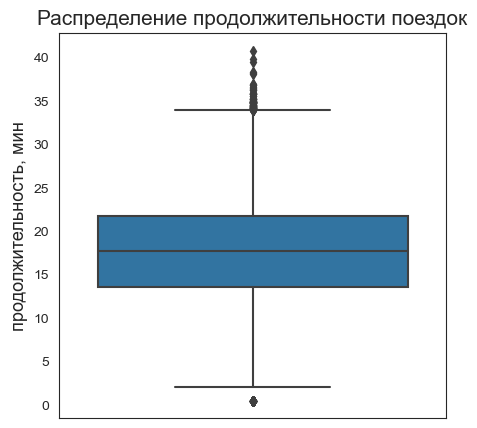

In [9]:
# продолжительность поездок

plt.figure(figsize=(5,5))
sns.set_style("white")
_ = sns.boxplot(y="duration", data=rides)
_.axes.set_title('Распределение продолжительности поездок', fontsize=15)
_.set_xlabel('')
_.set_ylabel('продолжительность, мин', fontsize=13)
plt.show()

На графике мы видим, что основная "масса" поездок сосредоточилась в диапазоне 15-23 минуты, и наблюдаются выбросы менее 2х минут и более 35 минут.

In [10]:
# посмотрим на строки с продолжительностью сессии менее 2х минут

rides.query('duration < 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [11]:
rides.query('duration < 2')['distance'].min()

4030.308008428866

В таблице `rides` 95 строк с продолжительностью поездки в районе минуты, при этом минимальное расстрояние (из этих данных) - 4 километра, значит в остальных 94 случаях расстояние, приодоленное за одну сессию еще больше, что явно говорит о наличии ошибки. Вероятно единицы измерения были неверно указаны или произошел сбой в сессии, неверно считалось ее продолжительность, либо произошла ошибка при загрузке/выгрузке данных. В данном случае, корректно указать продолжительность сессии нет возможности, чтобы не искажать последующее исследование - удалим эти строки (менее 1% таблицы rides).

In [12]:
rides.drop(index=rides.query('duration < 2').index, inplace=True)

In [13]:
# посмотрим на строки с продолжительностью сессии более 35 минут

rides.query('duration > 35')

,user_id,distance,duration,date,month
42,4,4649.488243,35.896929,2021-08-14,8
143,15,4187.621459,38.125729,2021-01-13,1
499,55,4151.081878,36.906491,2021-06-30,6
524,58,4763.920660,35.819603,2021-02-17,2
854,91,4444.579979,35.222900,2021-11-05,11
1111,119,4060.082639,35.360496,2021-05-15,5
1455,158,3967.285849,35.803715,2021-05-09,5
1621,174,3794.401307,35.766408,2021-12-23,12
1694,183,4473.798120,36.402535,2021-01-02,1
1894,205,4218.386189,36.310317,2021-08-26,8


В данном случае, нет оснований предполагать о каких либо выбросах или недостоверных или аномальных данных. Оставим без изменений.

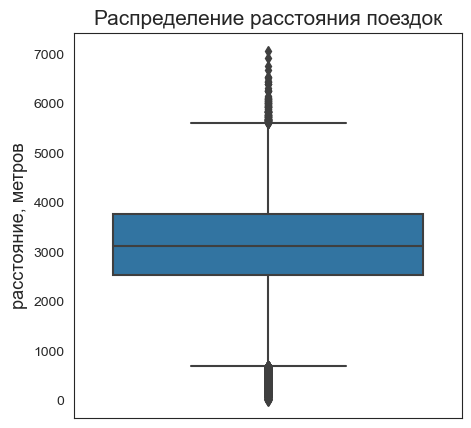

In [14]:
# расстояние за текущую сессию

plt.figure(figsize=(5,5))
sns.set_style("white")
_ = sns.boxplot(y="distance", data=rides)
_.axes.set_title('Распределение расстояния поездок', fontsize=15)
_.set_xlabel('')
_.set_ylabel('расстояние, метров', fontsize=13)
plt.show()

Здесь мы видим что "масса" поездок расположилась в диапазоне 2500 - 4000 метров. Выбросы при этом наблюдаются менее 600 метров и более 5600 метров.

In [15]:
# посмотрим на строки с расстоянием менее 600 метров за поездку

rides.query('distance < 600')

,user_id,distance,duration,date,month
197,21,518.341543,10.151870,2021-02-03,2
204,21,517.912395,14.219625,2021-10-01,10
228,24,409.829089,10.294197,2021-04-04,4
406,44,504.654111,4.513962,2021-01-25,1
463,50,307.532350,6.230129,2021-08-05,8
...,...,...,...,...,...
18007,1531,450.981518,15.591699,2021-02-14,2
18018,1531,375.107762,5.406654,2021-06-27,6
18031,1532,303.787850,7.792490,2021-05-21,5
18043,1533,310.488247,10.642389,2021-02-21,2


Более 700 строк, т.е. более 700 поездок, расстояние которых было менее 600 метров. Не стоит забывать и о поведении пользователей, для кого-то и пол километра это расстояние и предпочтут самокат. Другое дело, что при не таком большом расстоянии, время, затраченное на поездку, немного не соизмеримо. Но опять же могут произойти разные ситуации, пользователь в первый раз воспользовался сервисом и не разобрался с приложением или же с самокатом (не понравилось, исспугался и тд.), либо неполадки с телефоном, поменялись планы, брали самокат, но в итоге не поехали и т.д. В данном случае нет возможности заявлять об аномальности этих данных.  

Посмотрим еще на среднюю скорость в поездке у данных пользователей. Для этого найдем отношение расстояние поездок к их продолжительности, умножим на коэффициен, чтобы перевести в более понятное измерение километры/в час и найдем среднюю скорость среди всех поездок.

In [16]:
((rides.query('distance < 600')['distance'] / rides.query('distance < 600')['duration']) * 0.06).mean()

2.776731005785533

Чуть менее 3 км/ч средняя скорость передвижения среди этих пользователей, возможно они из той категории пользователей, которые предпочитают неспешные прогулки на электросамокатах.  
Оставим данные без изменений, к тому же, нас в большей степени интересует продолжительность поездок, для последующего расчета выручки.

In [17]:
# посмотрим на строки с расстоянием более 5600 метров за поездку

rides.query('distance > 5600')

,user_id,distance,duration,date,month
6312,677,5699.769662,18.213792,2021-03-12,3
6549,702,5924.120648,21.156693,2021-11-19,11
6754,716,5835.527411,20.506582,2021-11-05,11
6788,719,5648.444936,19.837195,2021-10-13,10
7026,736,5787.742203,15.890581,2021-02-09,2
...,...,...,...,...,...
17389,1488,5630.700924,24.356457,2021-06-12,6
17418,1490,5830.284286,20.660569,2021-01-22,1
17681,1508,5600.052517,19.586316,2021-11-14,11
17773,1514,6039.465068,26.421033,2021-09-28,9


In [18]:
# посмотрим на среднюю скорость поездки среди этих пользователей

((rides.query('distance > 5600')['distance'] / rides.query('distance > 5600')['duration']) * 0.06).mean()

15.052579311730023

15 км/ч что сопоставимо с допустимой скоростью передвижения по городу. Оставим эти строки без изменения.

In [19]:
# обновим индексы после изменений

rides.reset_index(drop= True , inplace= True )

Для дальнейшего анализа округлим продолжительность каждой поездки до следующего целого числа.

In [20]:
rides['duration'] = np.ceil(rides['duration'])

На этапе предобработки данных:
- столбец `date` таблицы **rides** был приведен к типу данных - датa
- в таблицу **rides** добавили столбец с номером месяца поездки
- удалили явные дубликаты в таблице **users**
- рассмотрели аномальные и выбивающиеся значения в таблице **rides** (удалили строки с продолжительностью поездки менее 2х минут)
- округлили продолжительность каждой поездки до следующего целого числа

## Шаг. Исследовательский анализ данных

### Частота встречаемости городов

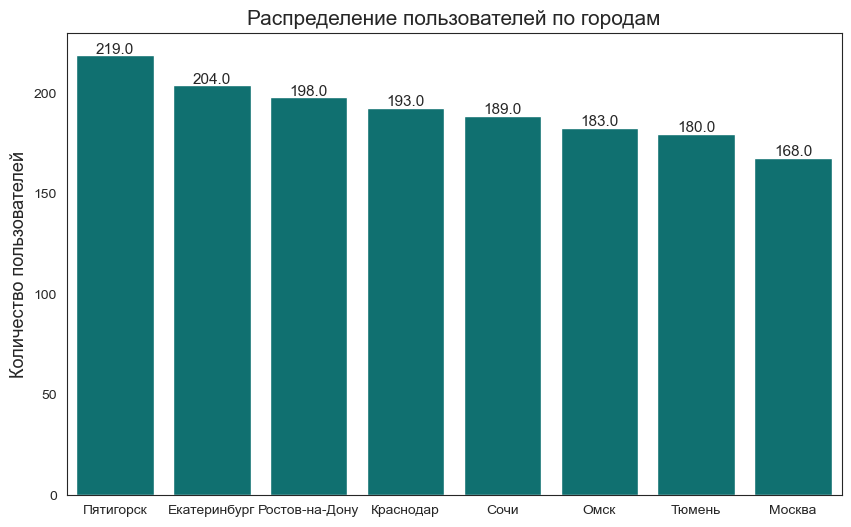

In [21]:
city_order = ['Пятигорск', 'Екатеринбург', 'Ростов-на-Дону', 'Краснодар', 'Сочи', 'Омск', 'Тюмень', 'Москва']

countplt, ax = plt.subplots(figsize = (10,6))
ax =sns.countplot(x = 'city', data=users, order = city_order, color='teal')
ax.set_title('Распределение пользователей по городам',fontsize = 15)
ax.set_xlabel('')
ax.set_ylabel('Количество пользователей', fontsize = 13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.show()

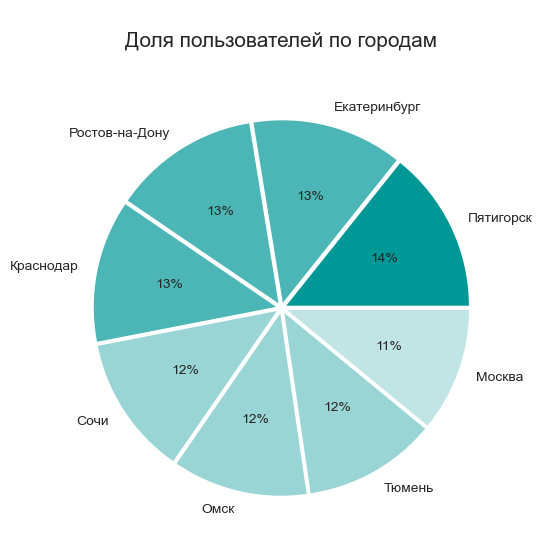

In [22]:
(users['city']
 .value_counts()
 .plot(kind='pie', figsize=(6,6), autopct='%1.0f%%',
       explode=(0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02),
       colors = ['#009797','#4cb6b6','#4cb6b6','#4cb6b6', '#99d5d5','#99d5d5','#99d5d5','#c1e5e5'])
)
plt.title('\nДоля пользователей по городам\n', fontsize = 15)
plt.ylabel('')
plt.show()

Согласно графиков, мы видим, что среди городов наблюдается незначительный разброс пользователей, как в абсолютном выражении, так и их долей. Так самый частовстречаемый город - Пятигорск (219 пользователей или 14% от общего количества), далее идут Екатеринбург и Ростов-на-Дону (204 и 198 пользователей соответственно). Замыкает распределение Москва (168 пользователей или 11%)

### Соотношение пользователей с подпиской и без подписки

In [23]:
print(f'\n\033[1;30m количество пользователей без подписки: \033[0m {users["subscription_type"].value_counts()[0]}\
          \n\033[1;30m количество пользователей с подпиской: \033[0m {users["subscription_type"].value_counts()[1]}')


 количество пользователей без подписки:  835          
 количество пользователей с подпиской:  699


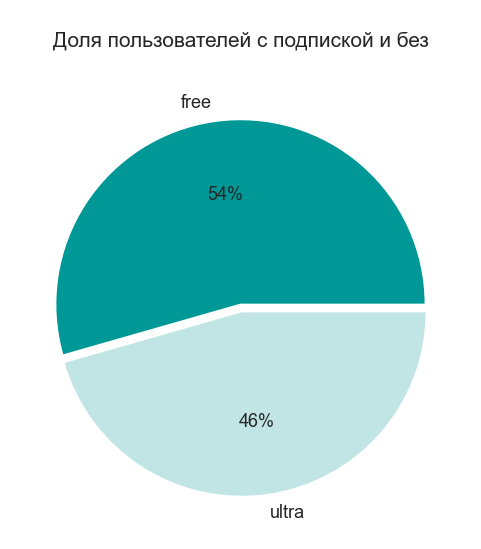

In [24]:
(users['subscription_type']
 .value_counts()
 .plot(kind='pie', figsize=(6,6), autopct='%1.0f%%',
       explode=(0.02, 0.02), textprops = {"fontsize":13},
       colors = ['#009797','#c1e5e5'])
)
plt.title('\nДоля пользователей с подпиской и без\n', fontsize = 15)
plt.ylabel('')
plt.show()

Как мы видим, по типу подписки, пользователи также различаются незначительно. 835 человек используют сервис без подписки (или 54%), 699 человек приобрели подписку ultra (46% пользователей).   

Рассмотрим далее как распределялось количество пользователей по типу подписки по городам.

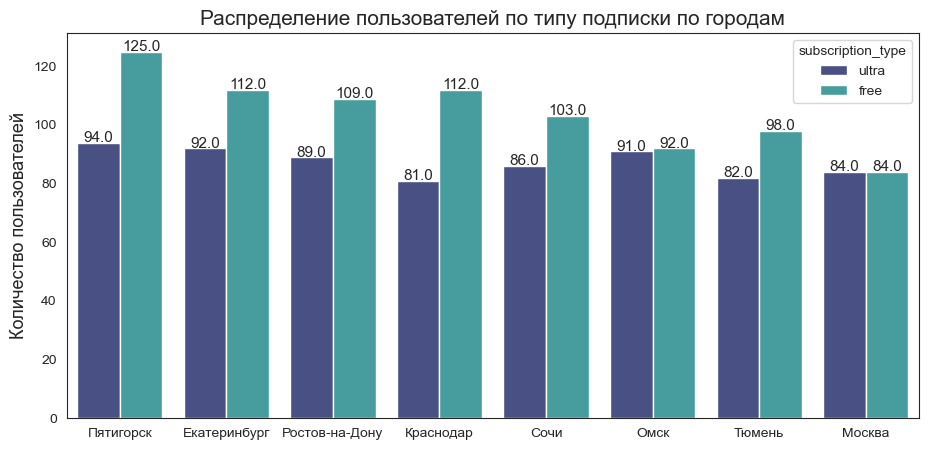

In [25]:
countplt, ax = plt.subplots(figsize = (11,5))
ax =sns.countplot(x = 'city', data=users, order = city_order, palette='mako', hue='subscription_type')
ax.set_title('Распределение пользователей по типу подписки по городам',fontsize = 15)
ax.set_xlabel('')
ax.set_ylabel('Количество пользователей', fontsize = 13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height()+ 0.25,rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.show()

И посмотрим на соотношение пользователей с подпиской в рамках одного города

In [26]:
_ = users.pivot_table(index='city', columns='subscription_type', values='user_id', aggfunc='count')
_['share_ultra'] = round(_['ultra']/(_['free']+_['ultra'])*100, 1)
_.sort_values(by='share_ultra', ascending=False).reset_index()

subscription_type,city,free,ultra,share_ultra
0,Москва,84,84,50.0
1,Омск,92,91,49.7
2,Тюмень,98,82,45.6
3,Сочи,103,86,45.5
4,Екатеринбург,112,92,45.1
5,Ростов-на-Дону,109,89,44.9
6,Пятигорск,125,94,42.9
7,Краснодар,112,81,42.0


- В абсолютном выражении снова лидирует Пятигорск, как по количеству пользователей с подпиской, так и без, но в процентном соотношении, в рамках одного города, Пятигорск занимает предпоследнее место по доли пользователей с подпиской (43%). 
- Хоть Москва занимает последнее место по количеству пользователей, в данном городе самое высокое соотношение пользователей с подпиской (50%). Примерно идентичную картину демонстрирует Омск, доля пользователей с подпиской ~ 50%.
- Меньше всего соотношение пользователей с подпиской к пользователям без абонементской платы в Краснодаре - 42% пользователей.

### Возраст пользователей

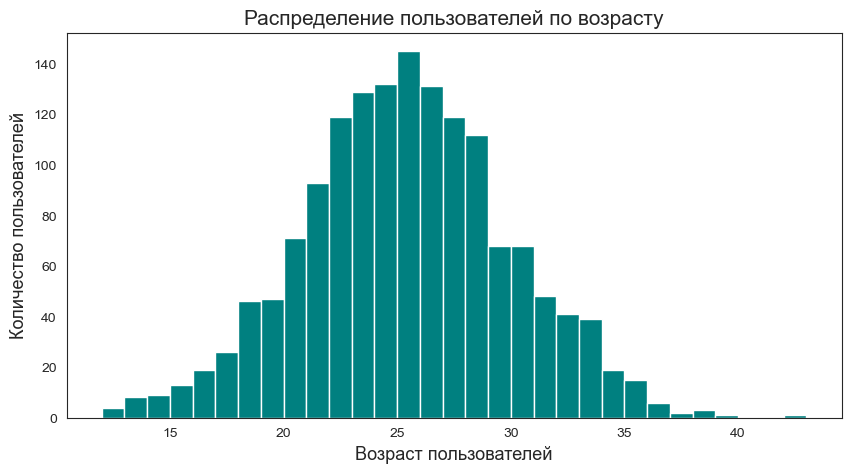

In [27]:
plt.figure(figsize=(10,5))
sns.histplot(data = users, x = 'age', color = 'teal',alpha = 1, binwidth = 1)
plt.title('Распределение пользователей по возрасту',fontsize = 15)
plt.xlabel('Возраст пользователей', fontsize = 13)
plt.ylabel('Количество пользователей', fontsize = 13)
plt.show()

Ранее мы писали, что согласно информации о таблице users, средний возраст пользователей - 25 лет, это отлично иллюстрируется на графике. Самый молодой пользователь в возрасте 12 лет, самому старшему - 43 года. Больше всего пользователей от 23 до 26 лет.  

Разобьем пользователей на возрастные категории, чтобы посмотреть как среди них распределилась подписка на сервис.  
Категории:
- `до 18 лет`
- `от 18 до 25`
- `от 26 до 32`
- `более 33 лет`

In [28]:
cut_labels = ['до 18 лет', 'от 18 до 25', 'от 26 до 32', 'более 33 лет']
cut_bins = [0, 17, 25, 32, 43]

users['age_category'] = pd.cut(users['age'], bins=cut_bins, labels=cut_labels)

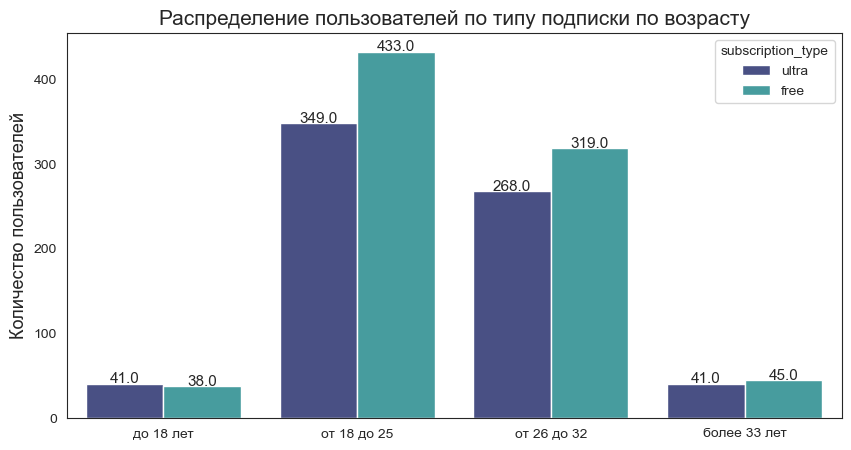

In [29]:
countplt, ax = plt.subplots(figsize = (10,5))
ax =sns.countplot(x = 'age_category', data=users, palette='mako', hue='subscription_type')
ax.set_title('Распределение пользователей по типу подписки по возрасту',fontsize = 15)
ax.set_xlabel('')
ax.set_ylabel('Количество пользователей', fontsize = 13)
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height()+ 0.25,rect.get_height(),horizontalalignment='center', fontsize = 11)
plt.show()

Самая многочисленная категория - от 18 до 25 лет, среди них около 45% пользователей оформили подписку.
Следующая круппа по количеству - от 26 до 32 лет, здесь около 46% пользователей используют сервис по абонементу.
Самые немногочисленные категории до 18 лет и более 33 лет. Среди них доли пользователей приблизительно равны, в категории до 18 лет процент пользователей оформивших подписку немного более 50%.

### Расстояние, которое пользователь преодолел за одну поездку

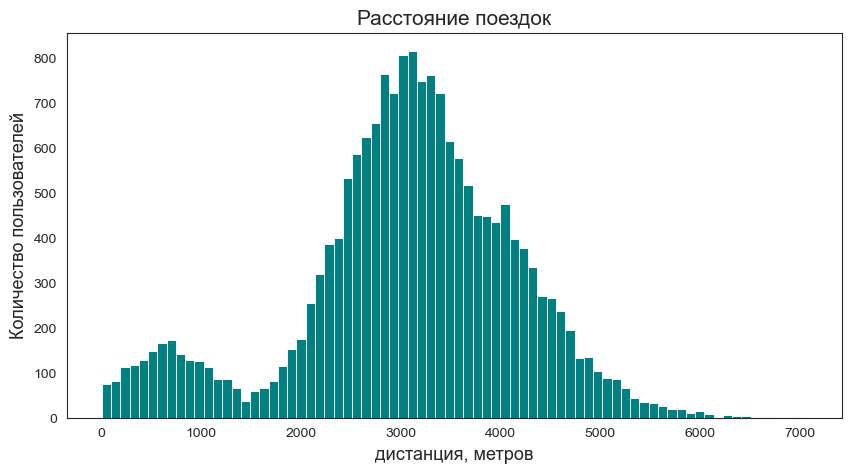

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(data = rides, x = 'distance', color = 'teal',alpha = 1)
plt.title('Расстояние поездок',fontsize = 15)
plt.xlabel('дистанция, метров', fontsize = 13)
plt.ylabel('Количество пользователей', fontsize = 13)
plt.show()

Чаще всего пользователи арендовали самокаты для поездок на расстояние от 2.5 до 3.5 километров, далее частота длинных поездок снижается и чем длиннее дистанция, тем таких поездок меньше. Видим небольшой "хребет" до 1.5 километров, что говорит о том, что пользователи достаточно часто арендуют самокаты для коротких дистанций.

### продолжительность поездок

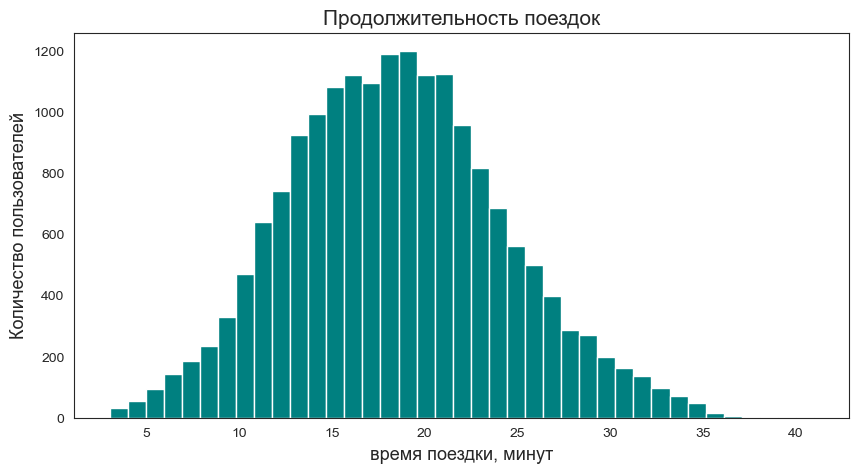

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(data = rides, x = 'duration', color = 'teal',alpha = 1, bins = 39)
plt.title('Продолжительность поездок',fontsize = 15)
plt.xlabel('время поездки, минут', fontsize = 13)
plt.ylabel('Количество пользователей', fontsize = 13)
plt.show()

Как мы видим из графика, продолжительность сессии пользователя в приложении GoFast чаще всего составляло 15-21 минуту. Количество поездок менее 8 минут и более 30 минут - незначительное (около 200), максимальная продолжительность аренды - 41 минута. 

- Больше всего пользователей приложения GoFast в Пятигорске (219 пользователей или 14% от общего количества), меньше всего - в Москве (168 пользователей или 11%). 
- По типу подписки, количество пользователей без абонементской платы преобладает, причем как в абсолютном, так и в процентном соотношении по всем городам, только в Москве и Омске доля пользователей с подпиской ULTRA составляет ~ 50 %. Меньше всего это соотношение в Краснодаре - 42% пользователей с подпиской ultra.
- Самый частовстречаемый возраст пользователей приложения от 23 до 26 лет. Самые немногочисленные категории - до 18 лет и старше 33 лет. Среди возрастных категорий, только в категории до 18 лет процент пользователей оформивших подписку немного более 50%, у остальных категорий количество пользователей без абонементской платы преобладает.
- Чаще всего пользователи арендовали самокаты для поездок на расстояние от 2.5 до 3.5 километров и по времени они занимали 15-21 минуту.

## Шаг. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [32]:
full_df = users.merge(rides, on = 'user_id')
full_df = full_df.merge(subscriptions, on = 'subscription_type')
display(full_df.sample(5))
full_df.info()

,user_id,name,age,city,subscription_type,age_category,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
10917,1025,Анжелика,25,Краснодар,free,от 18 до 25,4381.317550,16.0,2021-09-04,9,8,50,0
5980,639,Макар,23,Ростов-на-Дону,ultra,от 18 до 25,3514.142103,19.0,2021-08-30,8,6,0,199
1213,130,Алексей,22,Краснодар,ultra,от 18 до 25,244.210438,10.0,2021-12-13,12,6,0,199
626,68,Маргарита,27,Екатеринбург,ultra,от 26 до 32,2896.080243,15.0,2021-10-05,10,6,0,199
12909,1172,Егор,31,Ростов-на-Дону,free,от 26 до 32,1364.135439,19.0,2021-11-02,11,8,50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   user_id            17973 non-null  int64   
 1   name               17973 non-null  object  
 2   age                17973 non-null  int64   
 3   city               17973 non-null  object  
 4   subscription_type  17973 non-null  object  
 5   age_category       17973 non-null  category
 6   distance           17973 non-null  float64 
 7   duration           17973 non-null  float64 
 8   date               17973 non-null  object  
 9   month              17973 non-null  int64   
 10  minute_price       17973 non-null  int64   
 11  start_ride_price   17973 non-null  int64   
 12  subscription_fee   17973 non-null  int64   
dtypes: category(1), float64(2), int64(6), object(4)
memory usage: 1.8+ MB


In [33]:
print(f'в таблице users \033[1;30m{users.shape[0]}\033[0m строк и \033[1;30m{users.shape[1]}\033[0m столбцов\
        \nв таблице rides \033[1;30m{rides.shape[0]}\033[0m строк и \033[1;30m{rides.shape[1]}\033[0m столбцов\
        \nв таблице subscriptions \033[1;30m{subscriptions.shape[0]}\033[0m строк и \033[1;30m{subscriptions.shape[1]}\033[0m столбцов\
        \nв таблице full_df \033[1;30m{full_df.shape[0]}\033[0m строк и \033[1;30m{full_df.shape[1]}\033[0m столбцов')

в таблице users 1534 строк и 6 столбцов        
в таблице rides 17973 строк и 5 столбцов        
в таблице subscriptions 2 строк и 4 столбцов        
в таблице full_df 17973 строк и 13 столбцов


Максимальное количество строк у датасета rides (17973 строк), всего столбцов - 15, в нашем объедененном датафрейме - 13, т.к. 2 столбца общие. Размер объъединенной таблице соответствует ожиданиям. Данные объединились корректно.  

Создадим два датафрейма: c данными о пользователях без подписки и с данными о пользователях с подпиской.

In [34]:
df_free = full_df.query('subscription_type == "free"')
df_ultra = full_df.query('subscription_type == "ultra"')

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

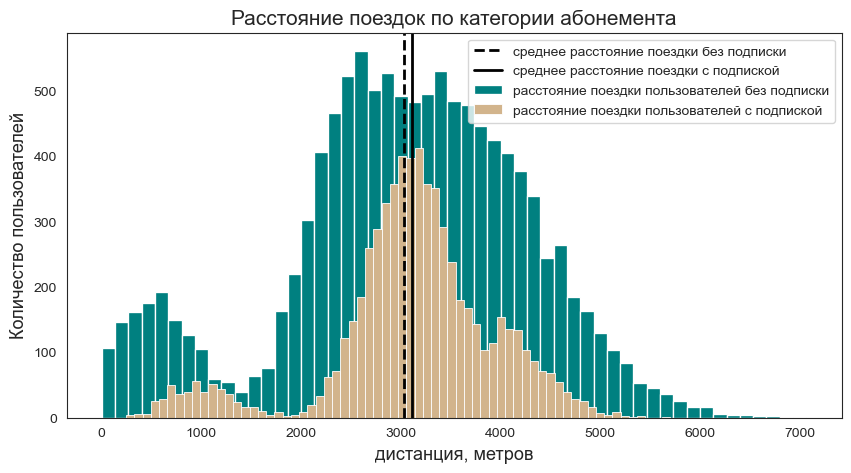

In [35]:
# расстояние поездок по категориям подписки

plt.figure(figsize=(10,5))
sns.histplot(data = df_free, x = 'distance', color = 'teal',alpha = 1, label='расстояние поездки пользователей без подписки')
sns.histplot(data = df_ultra, x = 'distance', color = 'tan',alpha = 1, label='расстояние поездки пользователей с подпиской')
plt.axvline(df_free['distance'].mean(), c='k', ls='--', lw=2, label='среднее расстояние поездки без подписки')
plt.axvline(df_ultra['distance'].mean(), c='k', ls='-', lw=2, label='среднее расстояние поездки с подпиской')
plt.title('Расстояние поездок по категории абонемента',fontsize = 15)
plt.xlabel('дистанция, метров', fontsize = 13)
plt.ylabel('Количество пользователей', fontsize = 13)
plt.legend()
plt.show()

Как мы выяснили ранее, количество пользователей без абонемента больше, это отражается и на графике. Форму графиков можно назвать идентичной, с небольшой корректировкой на пиковые и минимальные значения. В начале распределения у обеих категорий мы наблюдаем "хребты", для пользователей без абонемента эти значения лежат в диапазоне от 0 до 1.5 км, для пользователей с подпиской - от 200 метров до 2 км, можно предположить, что это расстояние до метро, общественного транспорта или до работы. Далее пользователи без подписки пользуются самокатами в более широком диапазоне с пиковыми значениями в районе 2.5 - 3.5 километров, тогда как расстояние пользователей с подпиской более скорцентрированно в районе 3х километров. Также стоит отметить, что максимальная дистанция у пользователей с абонементом - чуть более 5 км, а у пользователей без подписки - более 6 км. Среднее расстояние пользователей с подпиской немного длиннее среднего расстояния "бесплатных" пользователей.   

Далее посмотрим на плотность распределения расстояния поездок.

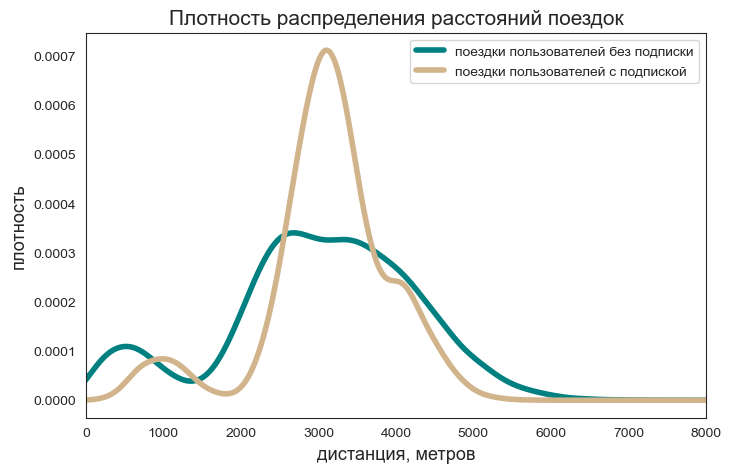

In [36]:
plt.figure(figsize=(8,5))
df_free.distance.plot.density(color='teal', linewidth=4, label='поездки пользователей без подписки')
df_ultra.distance.plot.density(color='tan', linewidth=4, label='поездки пользователей c подпиской')
plt.xlim([0, 8000])
plt.legend()
plt.title('Плотность распределения расстояний поездок',fontsize = 15)
plt.xlabel('дистанция, метров', fontsize = 13)
plt.ylabel('плотность', fontsize = 13)
plt.show()

Как мы и предполагали выше, пользователи с подпиской чаще всего используют самокаты на поездки около 3х километров, что может быть связано с регулярными поездками (работа, учеба, дела и т.д.), тогда как пользователи без подписки используют самокаты для поездок более широкого диапазона и менее сконцентрированно. 

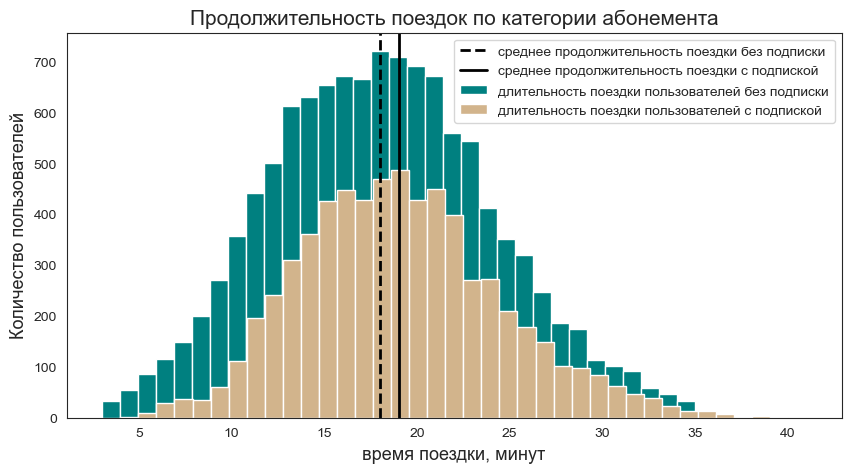

In [37]:
# продолжительность поездок по категориям подписки

plt.figure(figsize=(10,5))
sns.histplot(data = df_free, x = 'duration', color = 'teal',alpha = 1, bins = 33, label='длительность поездки пользователей без подписки')
sns.histplot(data = df_ultra, x = 'duration', color = 'tan',alpha = 1, bins = 38, label='длительность поездки пользователей с подпиской')
plt.axvline(df_free['duration'].mean(), c='k', ls='--', lw=2, label='среднее продолжительность поездки без подписки')
plt.axvline(df_ultra['duration'].mean(), c='k', ls='-', lw=2, label='среднее продолжительность поездки с подпиской')
plt.title('Продолжительность поездок по категории абонемента',fontsize = 15)
plt.xlabel('время поездки, минут', fontsize = 13)
plt.ylabel('Количество пользователей', fontsize = 13)
plt.legend()
plt.show()

В данном случае графики также имеют схожую направленность, для обеих категорий пиковые значения продолжительности поездки в районе 20 минут. Средняя же продолжительность клиентов с подпиской немного превышает продолжительность поездки пользователей без подписки.  

Посмотрим на плотность распределения длительности поездки.

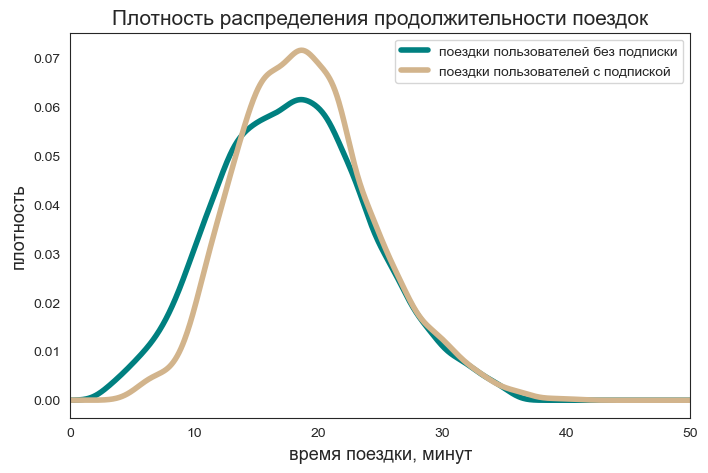

In [38]:
plt.figure(figsize=(8,5))
df_free.duration.plot.density(color='teal', linewidth=4, label='поездки пользователей без подписки')
df_ultra.duration.plot.density(color='tan', linewidth=4, label='поездки пользователей с подпиской')
plt.xlim([0, 50])
plt.legend()
plt.title('Плотность распределения продолжительности поездок',fontsize = 15)
plt.xlabel('время поездки, минут', fontsize = 13)
plt.ylabel('плотность', fontsize = 13)
plt.show()

У пользователей с подпиской более ярко выражены поездки протяженностью 15-20 минут по сравнению с пользователями без подписки, а пользователи без абонемента чаще берут самокат на короткие интервалы, по сравнению с пользователями с подпиской.  
Исходя из этого, можно предположить, что категория абонемента если и влияет на продолжительность поездки, то незначительно.

На данном этапе мы объединили данные о пользователях, поездках и подписках в один датафрейм, разделили его на две категории, в зависимости от типа подписки и визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий:
- чаще всего пользователи без подписки проезжают на самокатах от 2.5 до 3.5 км, у пользователей с подпиской это значение более сконцентрировано в районе 3х км, вероятно это связано с регулярностью поездок, их график менее широкий, чем у пользователей без подписки.
- по продолжительности поездок графики обеих категорий различаются незначительно, пиковое значение приходится на 20 минут, пользователи без абонемента чаще берут самокат на короткие интервалы, по сравнению с пользователями с подпиской.

## Шаг. Подсчёт выручки

Для каждого пользователя рассчитаем суммарное расстояние, количество поездок и суммарное время за каждый месяц.

In [39]:
rev_df = (full_df
          .groupby(['user_id', 'month'])
          .agg(
              count=('user_id', 'count'), 
              distance=('distance', 'sum'), 
              duration=('duration', 'sum'), 
              sub_type=('subscription_type', 'first'))
          .reset_index()
)
rev_df

,user_id,month,count,distance,duration,sub_type
0,1,1,2,7027.511294,42.0,ultra
1,1,4,1,754.159807,7.0,ultra
2,1,8,2,6723.470560,46.0,ultra
3,1,10,2,5809.911100,32.0,ultra
4,1,11,3,7003.499363,56.0,ultra
...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,free
11296,1534,8,2,7622.453034,48.0,free
11297,1534,9,1,4928.173852,23.0,free
11298,1534,11,4,13350.015305,78.0,free


Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.  

Помесячную выручку считаем по формуле:  
**стоимость старта поездки × количество поездок + стоимость 1 минуты × продолжительность всех поездок + стоимость подписки**.

In [40]:
rev_df['revenue'] = (
    np.select(
        condlist=[rev_df['sub_type'] == 'free', rev_df['sub_type'] == 'ultra'], 
        choicelist=[50 * rev_df['count'] + 8 * rev_df['duration'], 6 * rev_df['duration'] + 199], 
        default=0)
)
rev_df

,user_id,month,count,distance,duration,sub_type,revenue
0,1,1,2,7027.511294,42.0,ultra,451.0
1,1,4,1,754.159807,7.0,ultra,241.0
2,1,8,2,6723.470560,46.0,ultra,475.0
3,1,10,2,5809.911100,32.0,ultra,391.0
4,1,11,3,7003.499363,56.0,ultra,535.0
...,...,...,...,...,...,...,...
11295,1534,6,2,3409.468534,26.0,free,308.0
11296,1534,8,2,7622.453034,48.0,free,484.0
11297,1534,9,1,4928.173852,23.0,free,234.0
11298,1534,11,4,13350.015305,78.0,free,824.0


In [41]:
print(f'\033[1;30m годовая выручка c пользователей с подпиской: \033[0m{rev_df[rev_df["sub_type"]=="ultra"]["revenue"].sum()} рублей\
      \n\033[1;30m годовая выручка c пользователей без подписки: \033[0m{rev_df[rev_df["sub_type"]=="free"]["revenue"].sum()} рублей')

 годовая выручка c пользователей с подпиской: 1644537.0 рублей      
 годовая выручка c пользователей без подписки: 2228594.0 рублей


Создали аггригированный датафрейм с информацией о ежемесячной выручки с каждого пользователя.  
Ссумарная годовая выручка с пользователей без подписки превышает выручку с пользователей с абонементом. 

## Шаг. Проверка гипотез

### Гипотеза 1.  Пользователи с подпиской тратят больше времени на поездки.

Сформулируем нулевую и альтернативную гипотезы:  

**H0 :** продолжительность поездок пользователей с подпиской равна продолжительности пользователей без подписки  
**H1 :** продолжительность поездок пользователей с подпиской больше продолжительности пользователей без подписки  

Для проверки данной гипотезы воспользуемся t-тестом (scipy.stats.ttest_ind()), и так как у нас альтернативная гипотеза односторонняя, воспользуемся параметром **greater**.  

Уровень статистической значимости примем равным 5%.

In [42]:
duration_free = df_free['duration']
duration_ultra = df_ultra['duration']

alpha = 0.05 

results = st.ttest_ind(duration_ultra, duration_free, alternative='greater')

print(f'\033[1;30m p-value: \033[0m{results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')

 p-value: 8.577910347796266e-28

 Отвергаем нулевую гипотезу


Мы получили очень маленькое значение p-value, которое говорит о том, что наблюдаемое равенство в нулевой гипотезе маловероятно  и мы ее отвергаем в пользу альтернативной гипотезы.  

In [43]:
print(f'\033[1;30m средняя продолжительность поездок с ULTRA: \033[0m{round(df_ultra["duration"].mean(),2)} минут\
      \n\033[1;30m средняя продолжительность поездок без подписки: \033[0m{round(df_free["duration"].mean(),2)} минут')

 средняя продолжительность поездок с ULTRA: 19.04 минут      
 средняя продолжительность поездок без подписки: 18.03 минут


Таким образом гипотеза о равенстве продолжительности поездок пользователей с подпиской и без отвергается в пользу альтернативной гипотезы: **продолжительность поездок пользователей с подпиской больше продолжительности поездок пользователей без подписки**

### Гипотеза 2.  Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Сформулируем нулевую и альтернативную гипотезы:  

**H0 :** среднее расстояние, которое проезжают пользователи с подпиской равно 3130 метров  
**H1 :** среднее расстояние, которое проезжают пользователи с подпиской меньше 3130 метров  

Для проверки данной гипотезы воспользуемся t-тестом (scipy.stats.ttest_1samp()) чтобы сравнить значения выборки с нашим числом, и так как у нас альтернативная гипотеза односторонняя, воспользуемся параметром **less**.  

Уровень статистической значимости примем равным 5%.

In [44]:
distance_ultra = df_ultra['distance']

alpha = 0.05

interested_value = 3130

results = st.ttest_1samp(distance_ultra, interested_value, alternative='less')

print(f'\033[1;30m p-value: \033[0m{results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')

 p-value: 0.08046311521502146

 Нет оснований отвергнуть нулевую гипотезу


В данном случае значение p-value превышает уровень статистической значимости, поэтому оснований отвергать нулевую гипотезу (о равенстве среднего расстояния, которое проезжают пользователи с подпиской 3130 метров) у нас нет.  

In [45]:
print(f'\033[1;30m средняя дистанция поездки с ULTRA: \033[0m{round(df_ultra["distance"].mean(),2)} метров')

 средняя дистанция поездки с ULTRA: 3115.45 метров


Соответственно, **расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.**

### Гипотеза 3.  Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Сформулируем нулевую и альтернативную гипотезы:  

**H0 :** помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки  
**H1 :** помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки  

Для проверки данной гипотезы воспользуемся t-тестом (scipy.stats.ttest_ind()), и так как у нас альтернативная гипотеза односторонняя, воспользуемся параметром **greater**.  

Уровень статистической значимости примем равным 5%.

In [46]:
revenue_free = rev_df.query('sub_type == "free"')['revenue']
revenue_ultra = rev_df.query('sub_type == "ultra"')['revenue']

alpha = 0.05 

results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater')

print(f'\033[1;30m p-value: \033[0m{results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('\n\033[1;31;47m Отвергаем нулевую гипотезу\033[0m')
else:
    print('\n\033[1;32;47m Нет оснований отвергнуть нулевую гипотезу\033[0m')

 p-value: 2.0314113674863288e-30

 Отвергаем нулевую гипотезу


In [47]:
print(f'\033[1;30m среднемесячная выручка c пользователей с подпиской: \033[0m{round(rev_df[rev_df["sub_type"]=="ultra"]["revenue"].mean())} рублей\
      \n\033[1;30m среднемесячная выручка c пользователей без подписки: \033[0m{round(rev_df[rev_df["sub_type"]=="free"]["revenue"].mean())} рублей')

 среднемесячная выручка c пользователей с подпиской: 363 рублей      
 среднемесячная выручка c пользователей без подписки: 329 рублей


Нулевая гипотеза (о равенстве помесячной выручки от пользователей с подпиской и без) отвергается в пользу альтернативной гипотезы, что **помесячная выручка от пользователей с абонементом больше чем от "бесплатных" пользователей.** 

### Теоретическая часть.

Предположим: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

В данном случае мы бы имели дело с равенством средних для зависимых (парных) выборок и проверяли бы равны ли средние совокупности до и после этого изменения. Гипотезы в таком случае будут сформулированы так:  

**H0 :** среднее количество обращений до обновления равно среднему количеству обращений после обновления  
**H1 :** среднее количество обращений до обновления больше среднего количества обращений после обновления  

Чтобы проверить гипотезу о равенстве статистик применили бы метод **scipy.stats.ttest_rel()** с параметром **greater**.

С помощью статистических тестов мы проверили три гипотезы, таким образом:
- продолжительность поездок пользователей с подпиской больше продолжительности пользователей без подписки
- среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров
- помесячная выручка от пользователей с подпиской по месяцам больше выручки от пользователей без подписки  
Ответили на теоретический вопрос о равенстве статистик зависимых выборок (метод scypy.stats.ttest_rel()).

## Шаг. Распределения

### Ситуация первая

Отделу маркетинга GoFast нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %

Для решения поставленной задачи будем использовать метод stats.binom.cdf(k, n, p), где k - количество успешных исходов, n - количество попыток и р - вероятность успешного исхода. k и р нам известно (100 клиентов и вероятность 10%). Предположим что они раздадут промокод всем клиентам из нашего датафрейма (их у нас 1565).

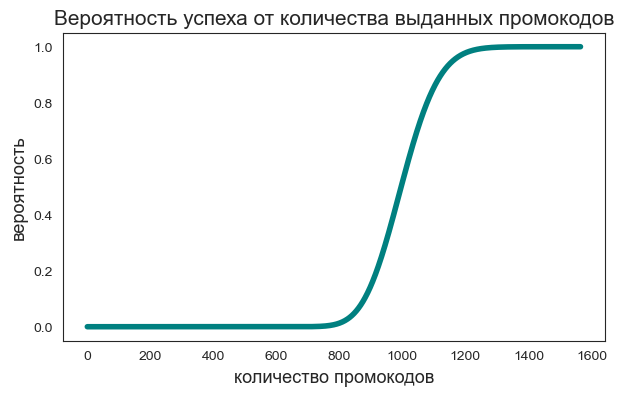

In [48]:
min_num = 100
p = 0.1

distr = []
for n in range(1, 1566):
    current = 1 - binom.cdf(min_num - 1, n, p)
    distr.append(current)

plt.figure(figsize=(7, 4))

plt.plot(range(1, 1566) , distr, color='teal', linewidth=4)
plt.xlabel('количество промокодов', fontsize = 13)
plt.ylabel('вероятность', fontsize = 13)
plt.title('Вероятность успеха от количества выданных промокодов', fontsize = 15)
plt.show()

Т.к. вероятность не выполнить план должна быть примерно 5 %, соответственно нас интересует 95% успеха.  
Согласно графику 95% успеха находится приблизительно на уровне 1100 (промокодов). Найдем это значение.

In [49]:
p_good = 0.95

while True:
    dist = st.binom(min_num, p)
    prob = 1 - dist.cdf(99)
    if prob >= p_good:
        break
    min_num += 1
print(f'Необходимо разослать минимум {min_num} промокод') 

Необходимо разослать минимум 1161 промокод


Проверим это значение

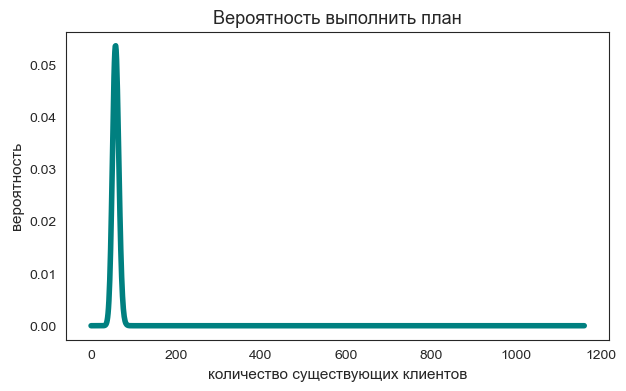

In [50]:
n = 1161
p = 0.05
x = range(n + 1)
y = binom.pmf(x, n, p)

plt.figure(figsize=(7, 4))
plt.plot(x, y, color='teal', linewidth=4)
plt.xlabel('количество существующих клиентов', fontsize = 11)
plt.ylabel('вероятность', fontsize = 11)
plt.title('Вероятность выполнить план', fontsize = 13)
plt.show()

**Чтобы вероятность не выполнить план была примерно 5 %, необходимо разослать 1161 промокод.**

### Ситуация вторая

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.  

Данная ситуация тоже описывается биномиальным распределением, но в данном случае воспользуемся нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки. 

In [51]:
n = 1000000 
p = 0.4 

mu = n * p  
sigma = sqrt(n * p * (1-p)) 

distr = st.norm(mu, sigma) 

result = distr.cdf(399500) 
print(f'Вероятность не более 399,5 тысяч открытых уведомлений равна \033[1;30m{round(result*100, 1)}%\033[0m')

Вероятность не более 399,5 тысяч открытых уведомлений равна 15.4%


Построим примерный график распределения

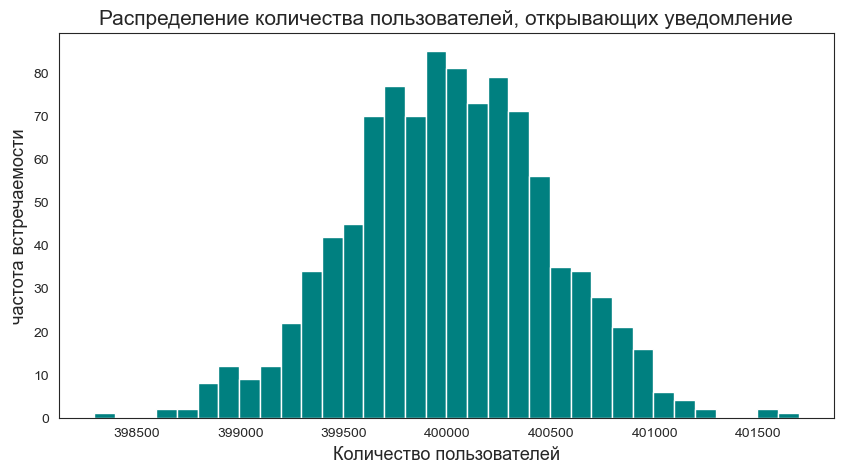

In [52]:
distr_push = np.random.normal(mu, sigma, 1000) 

plt.figure(figsize=(10,5))
sns.histplot(data = distr_push, color = 'teal',alpha = 1, binwidth = 100)
plt.title('Распределение количества пользователей, открывающих уведомление',fontsize = 15)
plt.xlabel('Количество пользователей', fontsize = 13)
plt.ylabel('частота встречаемости', fontsize = 13)
plt.show()

**Если разослать 1 млн. уведомлений, при том что 40% пользователей открывает их, вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равна 15.4%.**

## Выводы и рекомендации

На основании полученных данных мы проанализировали информацию о серсисе по аренде самокатов GoFast, его пользователях, их поездках и категории подписки за 2021 год.
- Всего в нашем датасете представлено 8 городов. Больше всего пользователей в Пятигорске (219 клиента или 14% от общего количества), далее идут Екатеринбург и Ростов-на-Дону (204 и 198 пользователей соответственно). Замыкает распределение Москва (168 пользователей или 11%)
- Среди всех пользователей 835 человек используют сервис без подписки (или 54%), 699 человек приобрели подписку ultra (46% пользователей). В Москве и Омсе доля пользователей с подпиской ~ 50%, в остальных городах этот показатель ниже - 42-45% "платных" пользователей. 
- Средний возраст пользователей - 25 лет, самому молодому - 12 лет, старшему - 43 года. Больше всего пользователей от 23 до 26 лет. Самая многочисленная категория - от 18 до 25 лет, среди них около 45% пользователей оформили подписку, и только в категории до 18 лет процент пользователей оформивших подписку немного более 50%, у остальных категорий количество пользователей без абонементской платы преобладает.  
- Чаще всего пользователи без подписки проезжают на самокатах от 2.5 до 3.5 км, у пользователей с подпиской это значение более сконцентрировано в районе 3х км, вероятно это связано с регулярностью поездок, их график менее широкий, чем у пользователей без подписки.
- По продолжительности поездок графики обеих категорий различаются незначительно, пиковое значение приходится на 20 минут, пользователи без абонемента чаще берут самокат на короткие интервалы, по сравнению с пользователями с подпиской.  
- Ссумарная годовая выручка с пользователей без подписки превышает выручку с пользователей с абонементом.

Было выдвинуто три гипотезы:  
- `Пользователи с подпиской тратят больше времени на поездки.`  
Гипотеза подтвердилась  
средняя продолжительность поездок с ULTRA: 19.04 минут  
средняя продолжительность поездок без подписки: 18.03 минут
- `Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.`  
Гипотеза подтвердилась  
средняя дистанция поездки с ULTRA: 3115.45 метров  
- `Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.`  
Гипотеза подтвердилась  
среднемесячная выручка c пользователей с подпиской: 363 рублей  
среднемесячная выручка c пользователей без подписки: 329 рублей  

Было рассмотрено две ситуации:
- Необходимо раздать минимум 1161 промокод, чтобы как минимум 100 существующих клиентов продлили свои подписки.
- Если разослать 1 млн. уведомлений, то с 15%-й вероятностью уведомление откроют не более 399,5 тыс. пользователей.

РЕКОМЕНДАЦИИ:  
- т.к. выручка от пользователей с подпиской выше, следует направить силы на удержание платящик клиентов, можно проанализировать самых активных и "прибыльных" пользователей, поощреть их за пользование сервисом, скидки на день рождения и т.д.
- конвертировать пользователей без подписки в платящих, т.к. их большинство: стоит также проанализировать самых активных и, предположим, выслать персональное предложение, что "с вашей активностью, имея подписку, вы сможете еще выгоднее наслаждаться нашим сервисом".
- проанализировать рынок Краснодара, там не самое малое количество пользователей, но процент платящик клиентов самый низкий.
- исходя из предыдущего пункта, расширять рынок Москвы, т.к. там доля платящик пользователей преобладает, но конечно стоит проанализировать все за и против из-за высокой конкуренции.
- стоит обратить внимание на категорию пользователей до 18 лет, среди них доля платящих выше, возможно рассмотреть применение различных скидочных систем и акций (тариф семейный, скидка студенту и т.д.)